In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
`%ni%` <- Negate(`%in%`)

working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays"

# load arguments
#args <- commandArgs(T)
#if(length(args)!=5){stop("Rscript normGBA.R <gene.sparse> <meta> <Zea_mays.AGPv4.36.Allgene.nuclear.bed> <prefix> <F>")}
#input_data <- as.character(args[1])
#meta <- as.character(args[2])
#gene <- as.character(args[3])
#prefix <- as.character(args[4])



#gene_bodysorghum_bicolor_tis_leaf_nmf_step_2_knn_27.out.de_novo.rds
input <- here(working_dir,"00.data/zea_mays.gene_body_acc_zea_may.v4_annot.counts.txt")
#input_2 <- here("/home/jpm73279/r_script_dev/lw_plotting","zea_mays.normalized_gene_acc_scores.leaf_svd_knn_100_strict.GBaccessibility.sparse")
meta <- here(working_dir,"00.data/Zm.leaf_annot.V5.meta.frozen.txt")
gene <- here(working_dir,"00.data/Zm.markers.leaf.txt")
c4_marker_list <- here(working_dir, "00.data/Zm_markers.Pm_bs_meso.markers.header.bed")
gene_DA <- here(working_dir,"00.data/Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed")
#prefix <- "TEST_SORGHUM_TEST"

meta_data <- read.delim(meta)
gene_markers <- read_delim(gene, col_types="cccccc")
c4_markers <- read_delim(c4_marker_list, col_types="cccccc") %>% 
    dplyr::filter(name %ni% gene_markers$name)

gene_markers <- gene_markers  %>%
    arrange(type)

gene_markers <- bind_rows(gene_markers, c4_markers)

all_markers <- gene_markers$geneID


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess



Attaching package: 'proxy'


The following object is masked from 'package:Matrix':

    as.matrix


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0.9000     v readr     2.1.4     
v ggplot2   3.4.1          v stringr   1.5.0     
v lubridate 1.9.2          v tibble    3.2.1     
v purrr     1.0.1          v tidyr     1.3.0     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::expand() masks Matrix::expand()
x dplyr::filter() m

In [2]:
raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

colnames(meta_data)

Rows: 22253352 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "cellID"                       "total"                       
 [3] "tss"                          "acrs"                        
 [5] "ptmt"                         "nSites"                      
 [7] "log10nSites"                  "pTSS"                        
 [9] "FRiP"                         "pOrg"                        
[11] "tss_z"                        "acr_z"                       
[13] "sites_z"                      "qc_check"                    
[15] "background"                   "cellbulk"                    
[17] "is_cell"                      "sampleID"                    
[19] "umap1"                        "umap2"                       
[21] "doubletscore"                 "d.type"                      
[23] "ptmt_ratio"                   "LouvainClusters"             
[25] "Zm_v4_annot"                  "Zm_v4_annot.subcluster_annot"
[27] "Zm.vasculature_lc"            "Zm.epidermis_lc"             
[29] "Zm.mesophyll_lc"              "v4_annotation_n"             
[31] "final_annotation_safe"        "final_annotation"            
[33] "reduce_resolution_annotation" "final_annotation_n"

In [3]:
tail(gene_markers)

chr,start,end,geneID,name,type,tissue
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr7,163342587,163346227,Zm00001eb323140,PPDK-RP_ortho_count_1,mesophyll,leaf
chr2,210448460,210451587,Zm00001eb106240,PPDK-RP_ortho_count_2,mesophyll,leaf
chr9,54920208,54922146,Zm00001eb382460,PPT_1_ortho_count_1__PPT_2_ortho_count_1,mesophyll,leaf
chr8,30519887,30522682,Zm00001eb339490,PPT_1_ortho_count_2__PPT_2_ortho_count_2,mesophyll,leaf
chr3,1534783,1538912,Zm00001eb118870,PPT_1_ortho_count_3__PPT_2_ortho_count_3,mesophyll,leaf
chr1,226422580,226426576,Zm00001eb042970,PPT_3__PPT_4,mesophyll,leaf


In [4]:
meta_data <- meta_data %>% 
  mutate(cell_type = case_when(reduce_resolution_annotation == "phloem_sieve_elements" ~ "companion_cells/sieve_elements",
                               reduce_resolution_annotation == "companion_cells" ~ "companion_cells/sieve_elements",
                               reduce_resolution_annotation == "companion_cells_sieve_elements" ~ "companion_cells/sieve_elements",
                               reduce_resolution_annotation == "mesophyll;developing" ~ "mesophyll developing",
                               TRUE ~ reduce_resolution_annotation)) %>% 
  dplyr::filter(is.na(cell_type) != TRUE)  %>%  
  mutate(cell_type = str_replace_all(cell_type, "_", " "))  %>% 
  mutate_at(vars(cell_type), 
            list(factor))


In [5]:
merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(cell_type, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
merged_meta_cpm_information_copied <- merged_meta_cpm_information
catch <- merged_meta_cpm_information_copied  %>%
    group_by(cell_type) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



caught_values <- as_tibble(catch)
see <- ungroup(merged_meta_cpm_information_copied)
merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
    rename(grouped_CPM = value)

`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


In [6]:

## Deprecated 3/18/2023
#file_names_altered <- c("zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.bundle_sheath_ncell_2035.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.companion_cell_ncell_714.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.developing_bundle_sheath_ncell_410.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.epidermis_ncell_3005.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.guard_cell_ncell_312.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.guard_mother_cell_ncell_82.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.leaf_primordia_ncell_466.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.mesophyll_ncell_4569.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.phloem_SE_ncell_1456.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.protoderm_ncell_1459.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.sclerenchymaous_bundle_sheath_ncell_396.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.unknown_ncell_234.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.vascular_parenchyma_like_ncell_25.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.vascular_phloem_like_ncell_31.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.xylem_ncell_79.NA.cluster_specific.tsv",
#"zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.DA_genes.xylem_parenchya_ncell_568.NA.cluster_specific.tsv")

#read_DA_genes_altered <- function(file_name){
#    
#    working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays"
#    replace_name <- paste0(working_dir, "/zea.V2_annot/zea_mays.annotation_V2.")
#    filtered <- read_tsv(here(working_dir,file_name), col_names = TRUE,id = "origin")  %>% 
#        mutate(origin = str_replace(origin, "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays/zea.V2_annot.equal_cell_pops/zea_mays.annotation_V2.", ""))  %>% 
#        mutate(origin = str_replace(origin, ".NA.cluster_specific.tsv", ""))  %>% 
#        filter(padj < .05)
#    
#    return(filtered)    
#}

#read_all_DA_genes_altered <- lapply(file_names_altered, read_DA_genes_altered)
#all_merge_values_altered <- data.table::rbindlist(read_all_DA_genes_altered)

In [7]:
#merge_values_altered <- all_merge_values_altered %>% 
#    group_by(origin) %>% 
#    slice_min(padj, n =100)

    

In [8]:
head(merged_meta_cpm_information_copied)
altered_deseq2 <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -cell_type, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(cell_type)  %>% 
    mutate(Zscore_group = scale(Zscore))

# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, cell_type, accessability, geneID) 


colnames(merged_meta_cellID_values_all_genes)
colnames(merged_meta_cellID_values_all_genes)

wider_all_genes_altered <- merged_meta_cellID_values_all_genes %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-cell_type, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability < 1 ~ 0,
                                                       accessability >= 1 ~ 1)) %>% 
                    group_by(cell_type, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))


colnames(merged_meta_cellID_values_all_genes)
merged_meta_cellID_values_all_genes %>% 
    group_by(cell_type) %>% 
    select(-accessability, -cellID) %>% 
    unique() %>% 
    summarise(count = n())

cell_type,geneID,counts,grouped_CPM
<fct>,<chr>,<dbl>,<dbl>
bundle sheath,Zm00001eb000010,57,10.3068512
bundle sheath,Zm00001eb000020,18,3.2547951
bundle sheath,Zm00001eb000050,2,0.3616439
bundle sheath,Zm00001eb000060,124,22.4219220
bundle sheath,Zm00001eb000070,56,10.1260293
bundle sheath,Zm00001eb000080,232,41.9506927


[1] "cellID"        "cell_type"     "accessability" "geneID"

[1] "cellID"        "cell_type"     "accessability" "geneID"

`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


[1] "cellID"        "cell_type"     "accessability" "geneID"

cell_type,count
<fct>,<int>
bundle sheath,35761
companion cells/sieve elements,34661
epidermis,35758
mesophyll,36515
procambial meristem,28430
protoderm,35584


In [9]:
### Updated DE-seq2 with only Well established Markers
good_marker_list <- c('pepc1', "cah1", "ssu1", "ssu2", "agp2", "me3", "sut1", "ccr1", "dct2", "mute",
                     "shr1_v4v5count_1", "sut7", 'sweet13a','sweet13b','sweet13c','sweet1b', "ba2", 
                      "cvp2", "fdl", "cvl2", "ad1", "gpat12", "acl1", "bm5", "fcp1", "ids1", "KCS1", 
                      "mdh6", "vt2","ZmAPL", "ZmSWEET11", "zyb14", "gpat11", "gpat12", "ocl5", "ocl4", 
                      "slac_v4v5count_1", "bhlh43", "dct2", "KCS1", "scr1", "ZmLAX2", "acl5", "pdf1", 
                      "pdf2", "ZmLRD3", "ad1", "ZmSMXL4_v4v5count_1", "SID1", "bk1_v4v5count_1", "ZmSMXL5")

good_gene_markers <- gene_markers  %>% 
    filter(name %in% good_marker_list)
head(good_gene_markers)

chr,start,end,geneID,name,type,tissue
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr2,40136770,40137925,Zm00001eb079890,fcp1,"L1_leaf_primordia,L1_root_tip,L1_stamen_primordia,L1_pistil_primordia axillaryBud;leaf",NA
chr10,14827732,14830329,Zm00001eb408920,sweet13a,abaxial_bundle_sheath.phloem_parenchyma leaf,NA
chr10,14592719,14595578,Zm00001eb408900,sweet13b,abaxial_bundle_sheath.phloem_parenchyma leaf,NA
chr3,95886707,95888621,Zm00001eb133100,sweet13c,abaxial_bundle_sheath.phloem_parenchyma leaf,NA
chr2,66223855,66236990,Zm00001eb084940,ba2,"axillary_meristem,branch_meristem,peripheral_zone_inflorescence_meristem,spikelet_pair_meristem,spikelet_meristem,upper_floral_meristem,lower_floral_meristem,pistil_primordia,stamen_primordia,provascular_strands,glume_primordia,lemma_primordia,palea_primordia axillaryBud;leaf;tassel;ear",NA
chr10,117179327,117180363,Zm00001eb422000,acl1,bulliform_cell axillaryBud;leaf,NA


In [10]:
### 7/23/2022 List of maarkers
good_marker_list <- c('pepc1', "cah1", "ssu1", "ssu2", "agp2", "me3", "sut1", "fama_v4v5count_1", 
                      "dct2", "shr2h", "shr2", "gl1", "ZmAAP6_4", "bhlh43","ocl1", "ZmOPS",
                     "shr1_v4v5count_1", "sut7", 'sweet13a','sweet13b','sweet13c','sweet1b', 
                      "cvp2", "fdl", "cvl2", "ad1", "fcp1", "ids1", "KCS1", 
                      "mdh6", "vt2","ZmAPL", "ZmSWEET11", "zyb14", "ocl5", "ocl4", "hkt1_2", "kch1",
                      "slac_v4v5count_1", "bhlh43", "dct2", "KCS1", "scr1", "ZmLAX2", "pdf1", 
                      "xcp1", "gpat12", "pdf1", "pdf2","snd1",
                      "pdf2", "ZmLRD3", "ad1", "ZmSMXL4_v4v5count_1", "ZmSMXL5", 
                     "AspAT_1__AspAT_2",                                                                                                                                     "AspAT_3__AspAT_4",                                                                                                                                     "CA_1__CA_2",                                                                                                                                           "Dit_1__Dit_2",                                                                                                                                         "Dit_3",
"NADP-MDH_1_ortho_count_1__NADP-MDH_2_ortho_count_1",
"NADP-MDH_1_ortho_count_2__NADP-MDH_2_ortho_count_2",
"NADP-MDH_3","NADP-ME_1_ortho_count_1__NADP-ME_2_ortho_count_1",
"NADP-ME_1_ortho_count_2__NADP-ME_2_ortho_count_2",
"PEP-CK_1_ortho_count_1__PEP-CK_2_ortho_count_1",
"PEP-CK_1_ortho_count_2__PEP-CK_2_ortho_count_2","PEP-CK_3","PEPC_1__PEPC_2",
"PPA1__PPA3_1","PPA2_1","PPA2_2__PPA3_2",
"PPDK_1_ortho_count_1__PPDK_2_ortho_count_1",
"PPDK_1_ortho_count_2__PPDK_2_ortho_count_2","PPDK-RP_ortho_count_1","PPDK-RP_ortho_count_2",
"PPT_1_ortho_count_1__PPT_2_ortho_count_1",
"PPT_1_ortho_count_2__PPT_2_ortho_count_2",
"PPT_1_ortho_count_3__PPT_2_ortho_count_3",
"PPT_3__PPT_4", "rca1", "rca3", "rca4",
"bass1", "cah1", "cah3", "cah4", "cah5")

good_gene_markers <- gene_markers  %>% 
    filter(name %in% good_marker_list)
head(good_gene_markers)

chr,start,end,geneID,name,type,tissue
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr2,40136770,40137925,Zm00001eb079890,fcp1,"L1_leaf_primordia,L1_root_tip,L1_stamen_primordia,L1_pistil_primordia axillaryBud;leaf",NA
chr10,14827732,14830329,Zm00001eb408920,sweet13a,abaxial_bundle_sheath.phloem_parenchyma leaf,NA
chr10,14592719,14595578,Zm00001eb408900,sweet13b,abaxial_bundle_sheath.phloem_parenchyma leaf,NA
chr3,95886707,95888621,Zm00001eb133100,sweet13c,abaxial_bundle_sheath.phloem_parenchyma leaf,NA
chr1,185941269,185953288,Zm00001eb033390,dct2,bundle_sheath axillaryBud;leaf,NA
chr1,258566321,258579264,Zm00001eb050790,bhlh43,bundle_sheath axillaryBud;leaf,NA


In [11]:
gene_markers %>% 
    dplyr::filter(name == "cah3")

chr,start,end,geneID,name,type,tissue
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr3,220941926,220957856,Zm00001eb158800,cah3,mesophyll leaf,NA


In [12]:
marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("cell_type", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))

Warning message in left_join(., gene_markers, by = c("geneID")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 2749 of `x` matches multiple rows in `y`.
i Row 93 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


In [13]:
head(marker_final_plotting)

cell_type,geneID,grouped_CPM,Zscore,Zscore_group,total_cells,proportion_expressing,chr,start,end,name,type,tissue
<fct>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
bundle sheath,Zm00001eb000010,10.3068512,1.44720533,2.03380714,2878,1.00764420,NA,NA,NA,NA,NA,NA
bundle sheath,Zm00001eb000020,3.2547951,-0.47491430,-0.51820720,2878,0.34746352,NA,NA,NA,NA,NA,NA
bundle sheath,Zm00001eb000050,0.3616439,-0.16143490,-0.10199798,2878,0.03474635,NA,NA,NA,NA,NA,NA
bundle sheath,Zm00001eb000060,22.4219220,-0.04595001,0.05133228,2878,2.08478110,NA,NA,NA,NA,NA,NA
bundle sheath,Zm00001eb000070,10.1260293,-0.39726593,-0.41511282,2878,1.11188325,NA,NA,NA,NA,NA,NA
bundle sheath,Zm00001eb000080,41.9506927,-0.15811539,-0.09759063,2878,3.92633773,NA,NA,NA,NA,NA,NA


In [14]:
test_marker_clust <- marker_final_plotting  %>% 
    filter(geneID %in% good_gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(cell_type, Zscore, name)  %>% 
    pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying

row.names(test_marker_clust) <- test_marker_clust$name  # put gene in `row`
test_marker_clust <- test_marker_clust[,-1] #drop gene column as now in rows
clust <- hclust(dist(test_marker_clust %>% as.matrix())) # hclust with distance matrix

In [15]:
mat <- marker_final_plotting %>% 
    filter(geneID %in% good_gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(cell_type, Zscore, name)  %>% 
    pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$name  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix

In [16]:
v_clust$labels

[1] "bundle.sheath"                  "companion.cells.sieve.elements"
[3] "epidermis"                      "mesophyll"                     
[5] "procambial.meristem"            "protoderm"

In [17]:
fixed_order_strings <- v_clust$labels[v_clust$order]
fixed_order_strings <- gsub("companion.cells.sieve.elements", "companion cells/sieve elements", fixed_order_strings)
fixed_order_strings <- gsub("\\.", " ", fixed_order_strings)

Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


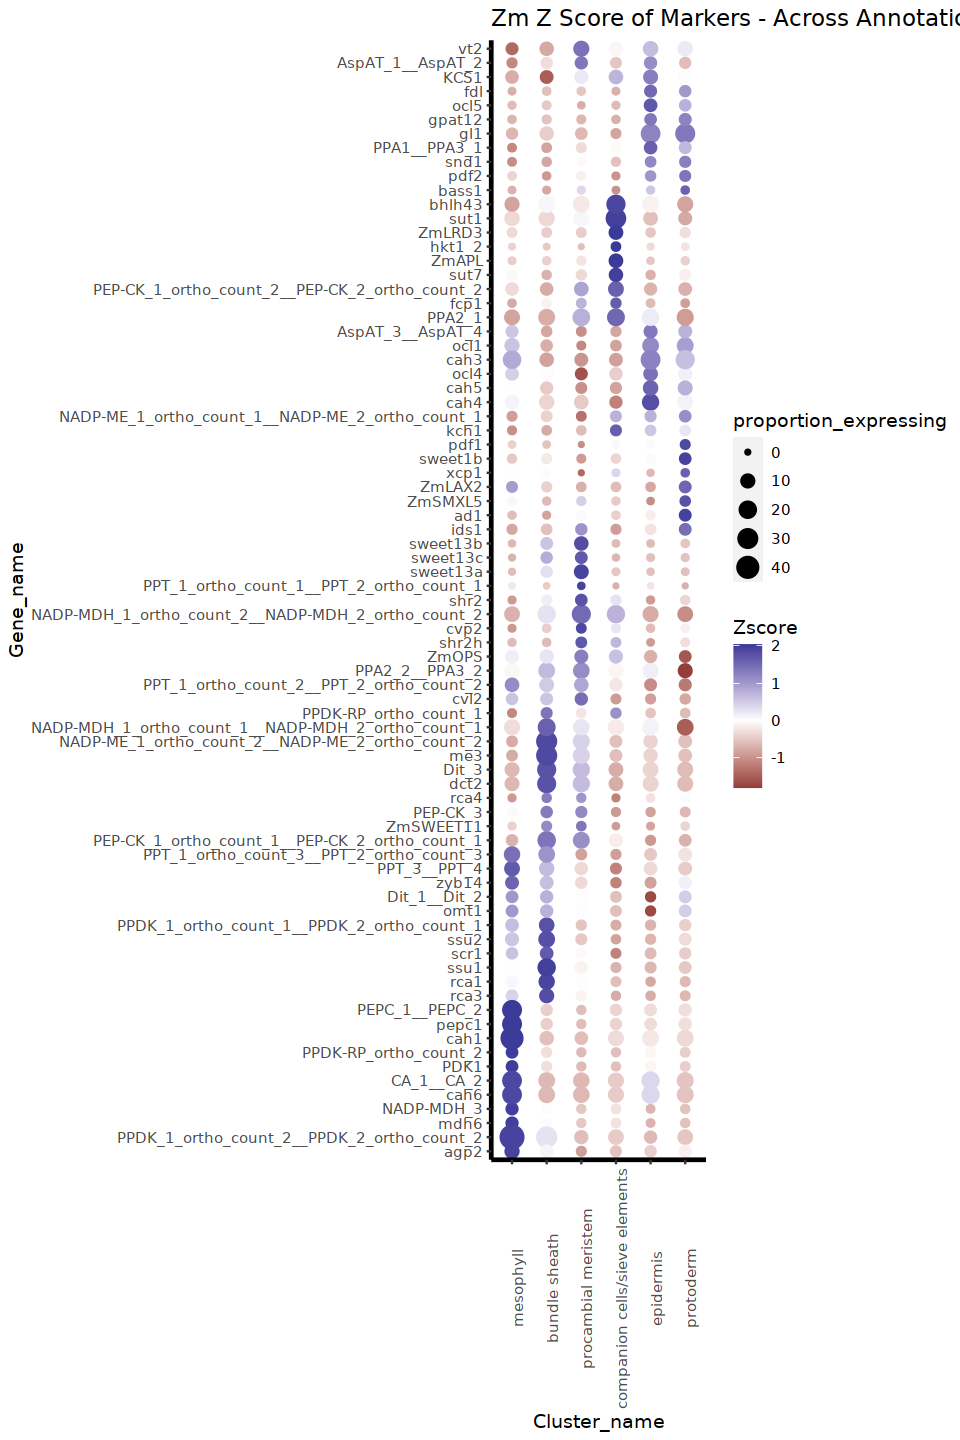

In [18]:
options(repr.plot.width=8, repr.plot.height=12)
supplamental_marker_dotplot_final <- marker_final_plotting  %>% 
    mutate(Gene_name = factor(name, clust$labels[clust$order]),
          Cluster_name = factor(cell_type, levels = fixed_order_strings)) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(x=Cluster_name, y = Gene_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Zm Z Score of Markers - Across Annotations")

supplamental_marker_dotplot_final

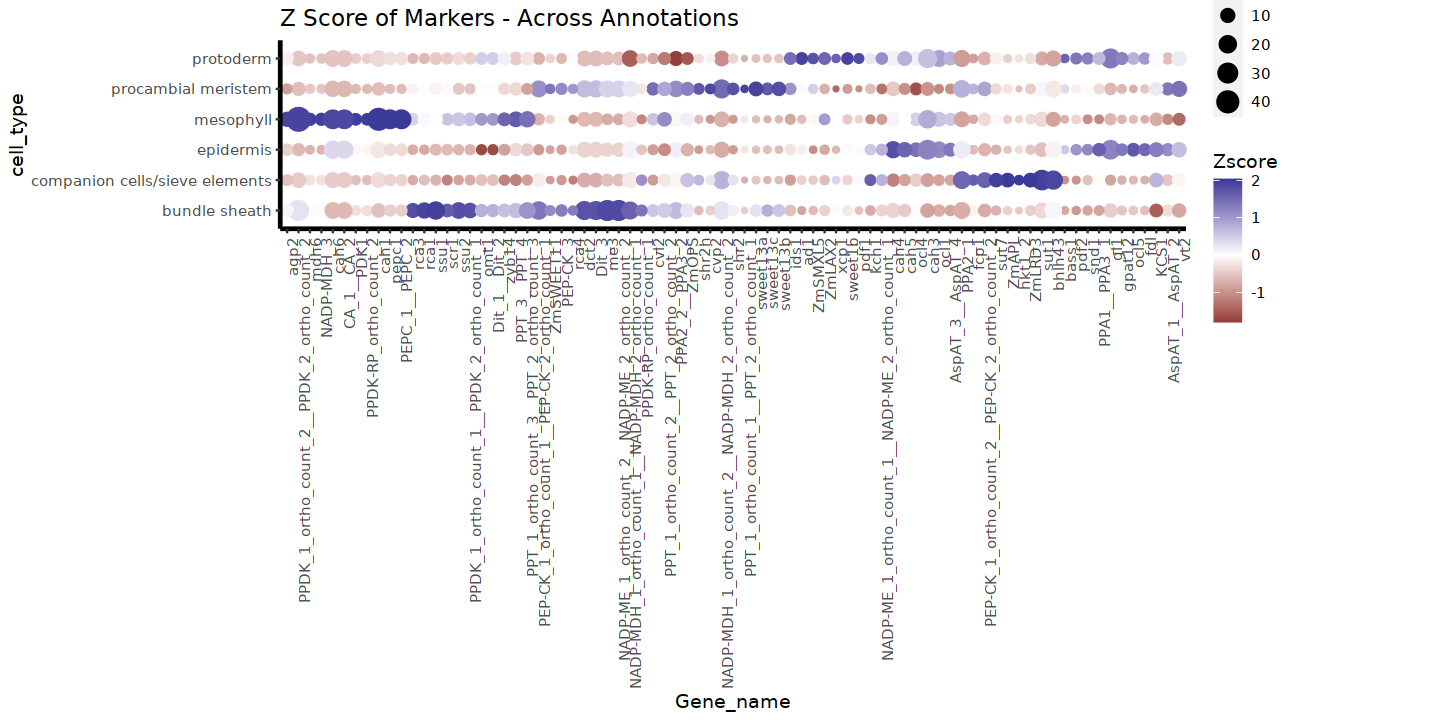

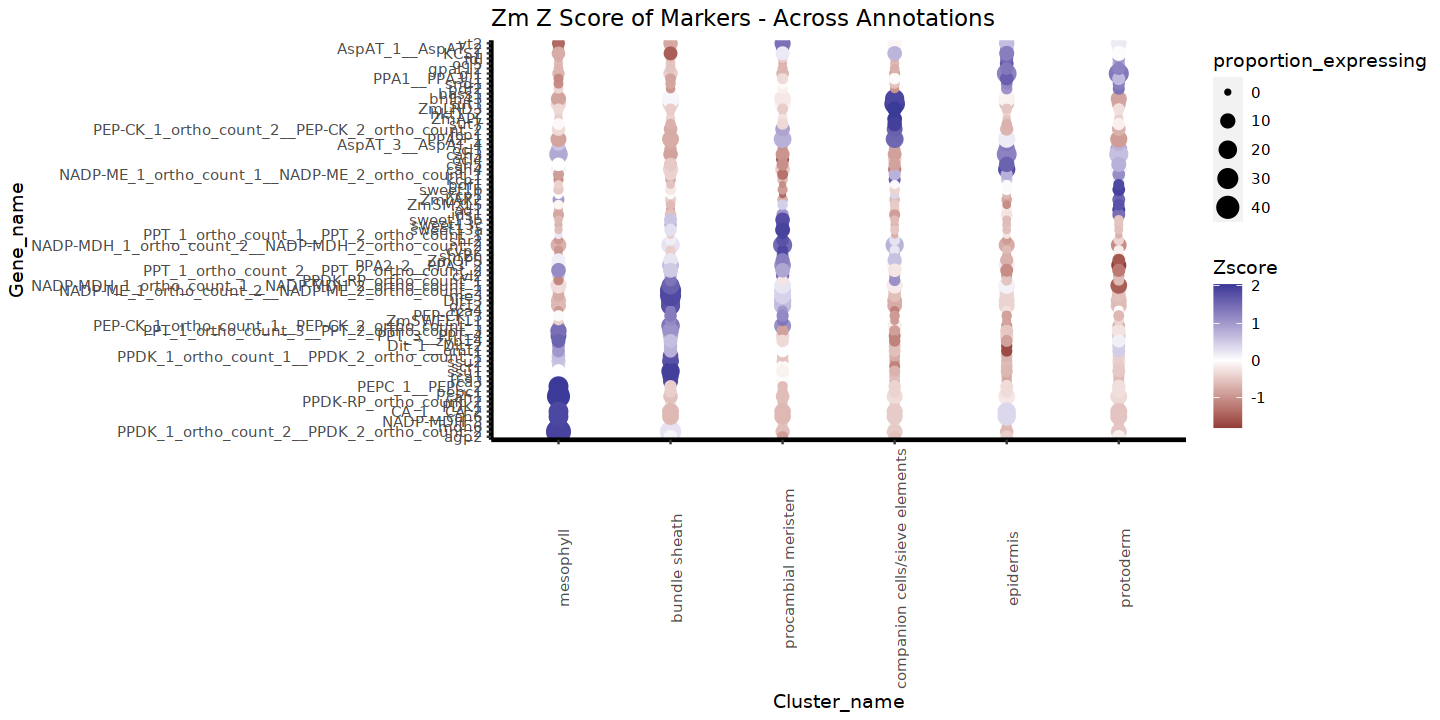

In [19]:
options(repr.plot.width=12, repr.plot.height=6)
marker_final_plotting  %>% 
    mutate(Gene_name = factor(name, clust$labels[clust$order]),
           Cluster_name = factor(cell_type, levels = fixed_order_strings)) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(y=cell_type, x = Gene_name, color = Zscore, size = proportion_expressing)) + 
    geom_point() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(), 
          panel.background = element_blank(), 
          axis.line.x = element_line(color="black", size = 1), 
          axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Z Score of Markers - Across Annotations")


supplamental_marker_dotplot_final

In [20]:
ggsave("zm_all_marker_dotplot.supplamental.pdf", plot = supplamental_marker_dotplot_final,
    path = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_1/dotplots",
    width = 8, height = 12,
    units = c('in'), limitsize = FALSE, dpi = 300)

# Generate Dotplot of HQ markers. 2-5 per cell type

In [21]:
head(marker_final_plotting)

cell_type,geneID,grouped_CPM,Zscore,Zscore_group,total_cells,proportion_expressing,chr,start,end,name,type,tissue
<fct>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
bundle sheath,Zm00001eb000010,10.3068512,1.44720533,2.03380714,2878,1.00764420,NA,NA,NA,NA,NA,NA
bundle sheath,Zm00001eb000020,3.2547951,-0.47491430,-0.51820720,2878,0.34746352,NA,NA,NA,NA,NA,NA
bundle sheath,Zm00001eb000050,0.3616439,-0.16143490,-0.10199798,2878,0.03474635,NA,NA,NA,NA,NA,NA
bundle sheath,Zm00001eb000060,22.4219220,-0.04595001,0.05133228,2878,2.08478110,NA,NA,NA,NA,NA,NA
bundle sheath,Zm00001eb000070,10.1260293,-0.39726593,-0.41511282,2878,1.11188325,NA,NA,NA,NA,NA,NA
bundle sheath,Zm00001eb000080,41.9506927,-0.15811539,-0.09759063,2878,3.92633773,NA,NA,NA,NA,NA,NA


In [22]:
### 7/23/2022 List of maarkers
good_marker_list <- c('pepc1',"PPDK_1_ortho_count_2__PPDK_2_ortho_count_2", "CA_1__CA_2", "cah1", #Ms Markers                      
                      "ssu1", "ssu2", "me3", "Dit_3",#BS Markers
                      "sut1", "sut7", "ZmAPL", "ZmLRD3",#companion cells
                      "shr2h", "shr2", "shr1_v4v5count_1", "cvp2", "ZmOPS", #vasculature/procambium
                      "gl1","gpat12","gpat11", #epidermis
                      "ocl1", "pdf2", "pdf1", #protoderm
                      "ocl1", "ocl4") #protoderm

good_gene_markers <- gene_markers  %>% 
    filter(name %in% good_marker_list)
head(good_gene_markers)

marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("cell_type", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))

chr,start,end,geneID,name,type,tissue
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr2,147040782,147041974,Zm00001eb092540,ssu2,bundle_sheath axillaryBud;leaf,NA
chr4,196177320,196178190,Zm00001eb197410,ssu1,bundle_sheath axillaryBud;leaf,NA
chr3,7184482,7190135,Zm00001eb121470,me3,bundle_sheath axillaryBud;leaf,NA
chr1,15196463,15201827,Zm00001eb005460,sut1,"companion_cells,xylem_parenchyma,phloem_parenchyma,pith_parenchyma axillaryBud;leaf;crownRoot;root;tassel;ear",NA
chr9,157693146,157697816,Zm00001eb402200,sut7,"companion_cells,xylem_parenchyma,phloem_parenchyma,pith_parenchyma axillaryBud;leaf;crownRoot;root;tassel;ear",NA
chr7,123684235,123693464,Zm00001eb313510,gl1,epidermis axillaryBud;leaf;crownRoot;root,NA


Warning message in left_join(., gene_markers, by = c("geneID")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 2749 of `x` matches multiple rows in `y`.
i Row 93 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


In [23]:
mat <- marker_final_plotting %>% 
    filter(name %in% good_gene_markers$name)  %>% 
    ungroup() %>% 
    dplyr::select(cell_type, Zscore, name)  %>% 
    dplyr::mutate(name = case_when(name == "pepc1" ~ "PEPC1", 
                                   name == "PPDK_1_ortho_count_2__PPDK_2_ortho_count_2" ~ "PDK2",
                                   name == "CA_1__CA_2" ~ "cah6", 
                                   name == "Dit_3" ~ "dct2",
                                   name == "ZmAPL" ~ "glk53",
                                   name == "ZmLRD3" ~ "limtf13",
                                   name == "shr1_v4v5count_1" ~ "gras58",
                                   TRUE ~ name
                                  )) %>% 
    dplyr::select(cell_type, Zscore, name)  %>% 
    pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
      data.frame() 

In [24]:
mat <- marker_final_plotting %>% 
    filter(name %in% good_gene_markers$name)  %>% 
    ungroup() %>% 
    dplyr::select(cell_type, Zscore, name)  %>% 
    dplyr::mutate(name = case_when(name == "pepc1" ~ "pepc1", 
                                   name == "PPDK_1_ortho_count_2__PPDK_2_ortho_count_2" ~ "PDK2",
                                   name == "CA_1__CA_2" ~ "cah6", 
                                   name == "Dit_3" ~ "dct2",
                                   name == "ZmAPL" ~ "glk53",
                                   name == "ZmLRD3" ~ "limtf13",
                                   name == "shr1_v4v5count_1" ~ "gras58",
                                   TRUE ~ name
                                  )) %>% 
    dplyr::select(cell_type, Zscore, name)  %>% 
    pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$name  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
clust <- hclust(dist(mat %>% as.matrix())) # hclust with distance matrix



fixed_order_strings <- v_clust$labels[v_clust$order]
fixed_order_strings <- gsub("companion.cells.sieve.elements", "companion cells/sieve elements", fixed_order_strings)
fixed_order_strings <- gsub("\\.", " ", fixed_order_strings)

In [25]:
v_clust$order

[1] 4 3 6 2 1 5

In [26]:
library(seriation)

Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy


Attaching package: 'seriation'


The following objects are masked from 'package:gplots':

    bluered, greenred




In [27]:
clust$labels[clust$order]

[1] "sut1"    "sut7"    "glk53"   "limtf13" "ZmOPS"   "shr2"    "shr2h"  
 [8] "cvp2"    "ocl4"    "ocl1"    "pdf1"    "gpat11"  "pdf2"    "gl1"    
[15] "gpat12"  "PDK2"    "cah6"    "cah1"    "pepc1"   "dct2"    "me3"    
[22] "ssu2"    "ssu1"

Warning message:
"package 'scales' was built under R version 4.2.1"

Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




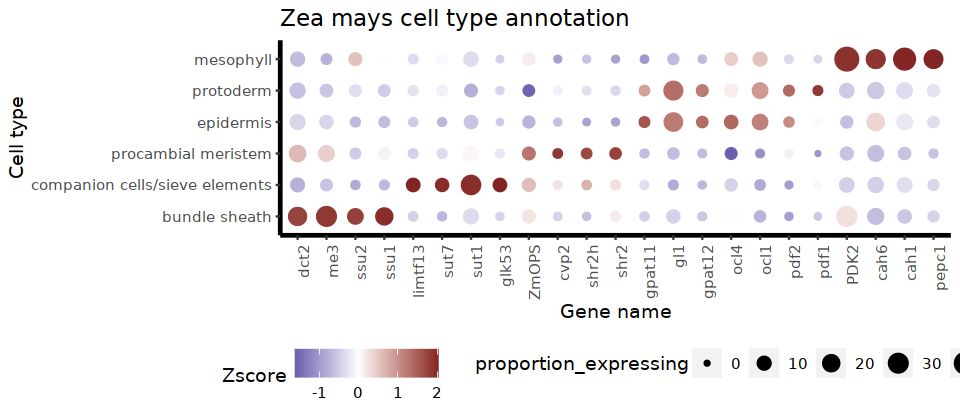

In [28]:
library(scales) # for muted
cell_order <- c('bundle sheath', 'companion cells/sieve elements', 'procambial meristem', 
                'epidermis', 'protoderm', 'mesophyll', 'mesophyll developing')

gene_array <- c('dct2','me3','ssu2','ssu1','limtf13','sut7','sut1','glk53',
    'ZmOPS','cvp2','shr2h','shr2',
    'gpat11','gl1','gpat12',
    'ocl4','ocl1','pdf2','pdf1',
    'PDK2','cah6','cah1','pepc1')

options(repr.plot.width=8, repr.plot.height=3.5)
figure_marker_dotplot <- marker_final_plotting  %>% 
    dplyr::mutate(name = case_when(name == "pepc1" ~ "pepc1", 
                                   name == "PPDK_1_ortho_count_2__PPDK_2_ortho_count_2" ~ "PDK2",
                                   name == "CA_1__CA_2" ~ "cah6", 
                                   name == "Dit_3" ~ "dct2",
                                   name == "Dit_3" ~ "dct2",
                                   name == "ZmAPL" ~ "glk53",
                                   name == "ZmLRD3" ~ "limtf13",
                                   name == "shr1_v4v5count_1" ~ "gras58",
                                   TRUE ~ name
                                  )) %>% 
    mutate(Gene_name = factor(name, levels = gene_array),
           Cluster_name = factor(cell_type, levels = cell_order)) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(y=Cluster_name, x = Gene_name, 
                  color = Zscore, size = proportion_expressing)) + 
    geom_point() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
          panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), 
          axis.line.y = element_line(color="black", size = 1), legend.position = "bottom",
          legend.box = "horizontal") +
    scale_colour_gradient2(low= muted("blue"), high=muted("red")) +
    ggtitle("Zea mays cell type annotation") +
    labs(x = "Gene name", y = "Cell type")  # This line was added

figure_marker_dotplot

In [29]:
ggsave("zm_selected_marker_dotplot.main_figure.pdf", plot = figure_marker_dotplot,
    path = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_1/dotplots",
    width = 8, height = 3.5,
    units = c('in'), limitsize = FALSE, dpi = 300)

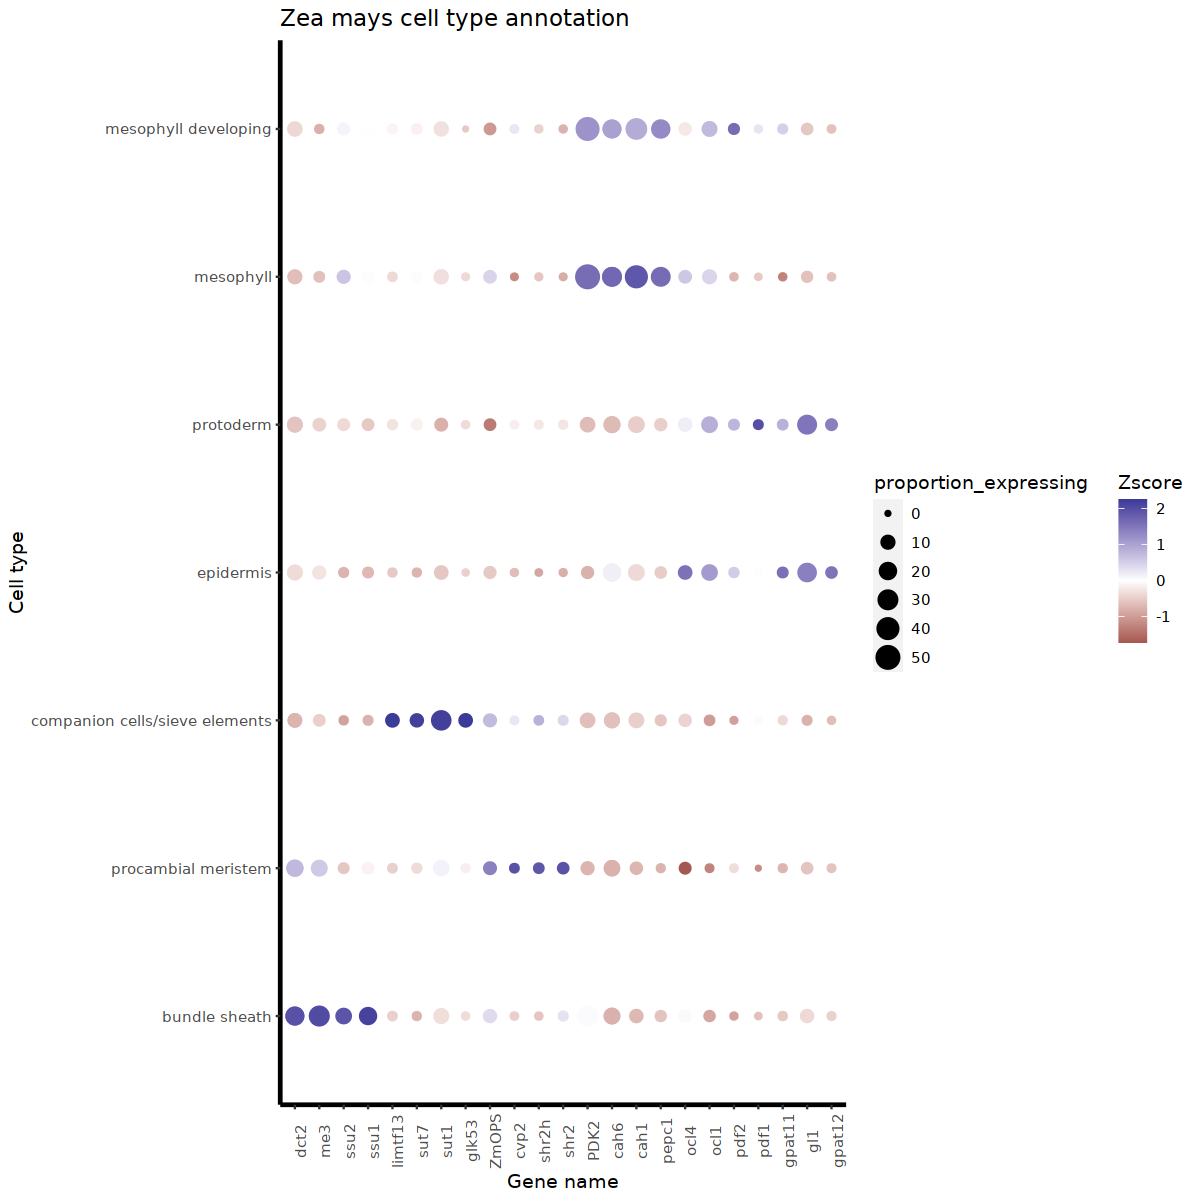

In [29]:
figure_marker_dotplot

In [28]:
options(repr.plot.width=10, repr.plot.height=10)
# Generate Quick graph about saturation of Tn5 per cluster 
library("ggdist")
meta_data  %>% 
    ggplot(., aes(x = cell_type, log(total))) + 
    geom_violin() +
      geom_boxplot(width = .2, coef = 0) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
    
meta_data  %>% 
    ggplot(., aes(x = cell_type, log(nSites))) + 
    geom_violin() +
      geom_boxplot(width = .2, coef = 0) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
    


ERROR: Error in library("ggdist"): there is no package called 'ggdist'


In [46]:
meta_data  %>% 
    group_by(cell_type)  %>% 
    summarise(mean_tn5 = mean(total),
              total_tn5 = sum(total), 
              quants = quantile(total, c(0.25, 0.5, 0.75)), q = c(0.25, 0.5, 0.75),
              counts = n())

`summarise()` has grouped output by 'V3_annotation_n'. You can override using the
`.groups` argument.


V3_annotation_n,mean_tn5,total_tn5,quants,q,counts
<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>
bundle_sheath_ncell_2870,5130.555,14724694,1674.75,0.25,2870
bundle_sheath_ncell_2870,5130.555,14724694,3162.50,0.50,2870
bundle_sheath_ncell_2870,5130.555,14724694,6235.00,0.75,2870
companion_cells_ncell_647,3794.986,2455356,1459.50,0.25,647
companion_cells_ncell_647,3794.986,2455356,2520.00,0.50,647
companion_cells_ncell_647,3794.986,2455356,4568.50,0.75,647
developing_mesophyll_ncell_494,4020.783,1986267,1548.00,0.25,494
developing_mesophyll_ncell_494,4020.783,1986267,2716.00,0.50,494
developing_mesophyll_ncell_494,4020.783,1986267,5103.50,0.75,494
